# Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('dataframe_2.pkl')

In [3]:
df.head()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect
0,55504.0,1.7,20800.0,37.8,39721.0,54487.0,3.9,13.5,87.6,24.6,93.371913,0.762305,0.025512,0
1,212628.0,16.7,75149.0,42.3,41286.0,56460.0,4.0,11.7,90.0,29.5,133.746808,0.810999,0.040973,0
2,25270.0,-8.0,9122.0,38.7,31788.0,32884.0,5.9,29.9,73.8,12.9,28.557545,0.491888,0.045390,0
3,22668.0,-1.1,7048.0,40.2,29264.0,43079.0,4.4,20.1,80.7,12.0,36.409779,0.766278,0.022146,0
4,58013.0,1.2,20619.0,40.8,31470.0,47213.0,4.0,14.1,80.0,13.0,89.973324,0.949322,0.086808,0


In [4]:
# drop rows with nans

df = df.dropna()

In [5]:
# inspect mean values of features for not-close vs close outcomes

df.groupby('close_elect').mean()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,97754.622861,0.673854,35383.793292,41.180151,40647.942847,49173.193018,4.611328,15.914203,85.657392,20.269884,251.164202,0.838362,0.088684
1,213686.159236,2.568153,77334.891720,38.888535,42207.388535,53773.019108,4.530573,15.549045,88.495541,27.620382,317.779807,0.760183,0.095176


## Model Preprocessing
- Calculate null accuracy
- Define feature matrix and response vector
- Split data into test/train
- Scale feature (X) matricies

In [6]:
# baseline, null model accuracy - guess '0' every time

(df['close_elect'] == 0).sum() / len(df)

0.9490094186424164

In [7]:
# initialize feature matrix and observed outcome

X = df.iloc[:, 0:13]
y = df.iloc[:, 13]

## Model Preprocessing

In [8]:
# test/train split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
# standardize training set
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# transform train data
X_train_trans = scaler.transform(X_train)
X_train_trans = pd.DataFrame(X_train_trans)

# transform test data
X_test_trans = scaler.transform(X_test)
X_test_trans = pd.DataFrame(X_test_trans)

# model input
X_train_mod = X_train_trans
y_train_mod = y_train

X_test_mod = X_test_trans
y_test_mod = y_test

In [10]:
# smote to increase underrepresented sampling

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_sample(X_train, y_train)

In [11]:
# standardize training set
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_res)

# transform train data
X_train_trans = scaler.transform(X_res)
X_train_trans = pd.DataFrame(X_train_trans)

# transform test data
X_test_trans = scaler.transform(X_test)
X_test_trans = pd.DataFrame(X_test_trans)

# model input
X_train_smote = X_train_trans
y_train_smote = y_res

X_test_smote = X_test_trans
y_test_smote = y_test

In [12]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

## Logistic Regression

### Initial Model

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_mod, y_train_mod)
y_pred = logreg.predict(X_test_mod)

In [14]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[876,   0],
       [ 48,   0]])

### Precision/Recall

In [20]:
y_prob_logreg = logreg.predict_proba(X_test_mod)[:,1]

In [21]:
# for plot

logreg_p, logreg_r, logreg_t = precision_recall_curve(y_test_mod, y_prob_logreg)

### Threshold Model

In [16]:
y_pred_proba = logreg.predict_proba(X_test_mod)

In [17]:
y_pred = y_pred_proba >= 0.05

In [18]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       0.97      0.74      0.84       876
          1       0.11      0.62      0.19        48

avg / total       0.93      0.73      0.80       924



In [19]:
metrics.confusion_matrix(y_test_mod, y_pred[:, 1])

array([[644, 232],
       [ 18,  30]])

### Weighted Model

In [35]:
logreg_wgt = LogisticRegression(class_weight="balanced")
logreg_wgt.fit(X_train_mod, y_train_mod)
y_pred = logreg_wgt.predict(X_test_mod)

In [36]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.77      0.86       876
          1       0.14      0.67      0.23        48

avg / total       0.93      0.77      0.83       924



### SMOTE

In [26]:
logreg_smote = LogisticRegression()
logreg_smote.fit(X_train_smote, y_train_smote)
y_pred = logreg_smote.predict(X_test_smote)

In [28]:
print(metrics.classification_report(y_test_smote, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.78      0.86       876
          1       0.13      0.60      0.21        48

avg / total       0.93      0.77      0.83       924



### Grid Search

In [37]:
# grid search

param_grid = {'C': np.logspace(-5, 5, 100)}
grid_search = GridSearchCV(logreg_wgt, param_grid, cv=5, scoring="recall")

In [38]:
best_model = grid_search.fit(X_train_mod, y_train_mod)

In [39]:
grid_search.best_params_

{'C': 0.010722672220103232}

In [42]:
logreg_grid = LogisticRegression(C=0.010722672220103232, class_weight="balanced")
logreg_grid.fit(X_train_mod, y_train_mod)
y_pred = logreg_grid.predict(X_test_mod)

In [43]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.75      0.85       876
          1       0.13      0.67      0.22        48

avg / total       0.93      0.75      0.82       924



## SVM

### Initial Model

In [44]:
from sklearn import svm

In [45]:
rbf_svm = svm.SVC(kernel='rbf', probability=True)
rbf_svm.fit(X_train_mod, y_train_mod)
y_pred = rbf_svm.predict(X_test_mod)

In [46]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
metrics.confusion_matrix(y_test, y_pred)

array([[876,   0],
       [ 48,   0]])

In [44]:
y_scores = cross_val_predict(rbf_svm, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.5786901270772239

### Precision/Recall

In [48]:
y_prob_svm = rbf_svm.predict_proba(X_test_mod)[:,1]

In [49]:
rbf_svm_p, rbf_svm_r, rbf_svm_t = precision_recall_curve(y_test_mod, y_prob_svm)

## KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

In [51]:
# search for an optimal value of K for KNN

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_mod, y_train_mod)
y_pred = knn.predict(X_test_mod)

In [52]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



In [53]:
metrics.confusion_matrix(y_test, y_pred)

array([[875,   1],
       [ 48,   0]])

In [54]:
y_scores = cross_val_predict(knn, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.0

### Precision/Recall

In [55]:
y_prob_knn = knn.predict_proba(X_test_mod)[:,1]

In [56]:
knn_p, knn_r, knn_t = precision_recall_curve(y_test_mod, y_prob_knn)

### Grid Search

In [44]:
from sklearn.model_selection import GridSearchCV

In [84]:
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)

In [85]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='recall')
grid.fit(X_train_mod, y_train_mod)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [86]:
print(grid.best_score_)
print(grid.best_params_)

0.9941348973607038
{'n_neighbors': 5}


In [87]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_mod, y_train_mod)
y_pred = knn.predict(X_test_mod)

In [88]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.79      0.87       876
          1       0.12      0.54      0.20        48

avg / total       0.93      0.78      0.84       924



## Random Forest

### Initial Model

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train_mod, y_train_mod)
y_pred = random_forest.predict(X_test_mod)

In [73]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.33      0.04      0.07        48

avg / total       0.92      0.95      0.93       924



In [74]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[872,   4],
       [ 46,   2]])

### Precision/Recall

In [61]:
y_scores = cross_val_predict(random_forest, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.004176334106728539

In [62]:
y_prob_random_forest = random_forest.predict_proba(X_test_mod)[:, 1]

In [63]:
random_forest_p, random_forest_r, random_forest_t = precision_recall_curve(y_test_mod, y_prob_random_forest)

### Threshold Model

In [64]:
y_pred_proba = random_forest.predict_proba(X_test_mod)

In [65]:
y_pred = y_pred_proba >= 0.05

In [66]:
metrics.confusion_matrix(y_test_mod, y_pred[:, 1])

array([[622, 254],
       [ 20,  28]])

In [67]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       0.97      0.71      0.82       876
          1       0.10      0.58      0.17        48

avg / total       0.92      0.70      0.79       924



### Weighted Model

In [68]:
random_forest = RandomForestClassifier(class_weight="balanced")
random_forest.fit(X_train_mod, y_train_mod)
y_pred = random_forest.predict(X_test_mod)

In [69]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.94      0.92       924



### SMOTE

In [75]:
random_forest_smote = RandomForestClassifier()
random_forest_smote.fit(X_train_smote, y_train_smote)
y_pred = random_forest_smote.predict(X_test_smote)

In [76]:
print(metrics.classification_report(y_test_smote, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.95      0.95       876
          1       0.15      0.17      0.16        48

avg / total       0.91      0.91      0.91       924



### Grid Search

In [77]:
param_grid = {'n_estimators': range(20, 40), 'max_features': np.linspace(1, 40, 1)}
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring="recall")

In [78]:
best_model = grid_search.fit(X_train_mod, y_train_mod)

In [79]:
grid_search.best_params_

{'max_features': 1.0, 'n_estimators': 31}

In [80]:
random_forest_grid = RandomForestClassifier(max_features=1, n_estimators=31)
random_forest_grid.fit(X_train, y_train)
y_pred = random_forest_grid.predict(X_test_mod)

In [81]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gaussian-Bayes

### Initial Model

In [83]:
from sklearn import naive_bayes, metrics

In [84]:
gb = naive_bayes.GaussianNB()
gb.fit(X_train_mod, y_train_mod)
y_pred = gb.predict(X_test_mod)

In [85]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.91      0.93       876
          1       0.11      0.19      0.14        48

avg / total       0.91      0.88      0.89       924



In [86]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[801,  75],
       [ 39,   9]])

### Precision/Recall

In [87]:
y_scores = cross_val_predict(gb, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.09791183294663573

In [88]:
y_prob_gb = gb.predict_proba(X_test_mod)[:, 1]

In [89]:
gb_p, gb_r, gb_t = precision_recall_curve(y_test_mod, y_prob_gb)

## Precision-Recall Plot

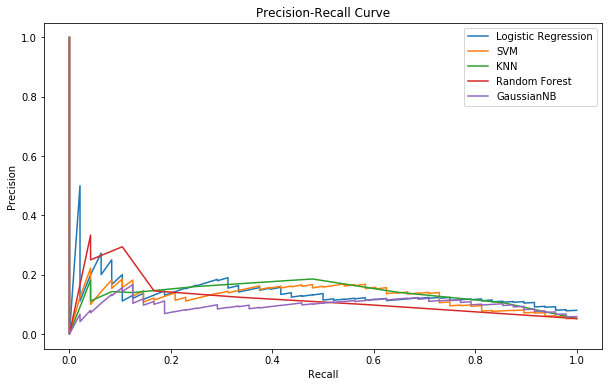

In [90]:
# plot P-R for all models

fig, ax = plt.subplots(figsize=(10, 6))

# Logisitic Regression
ax.plot(logreg_r, logreg_p, label='Logistic Regression')
# SVM
ax.plot(rbf_svm_r, rbf_svm_p, label='SVM')
#ax.step(rbf_svm_r, rbf_svm_p, color='b', alpha=0.2, where='post')
#ax.fill_between(rbf_svm_r, rbf_svm_p, step='post', alpha=0.2, color='b')
# KNN
ax.plot(knn_r, knn_p, label='KNN')
# Random Forest
ax.plot(random_forest_r, random_forest_p, label='Random Forest')
# Gaussian-Bayes
ax.plot(gb_r, gb_p, label='GaussianNB')

# ax.set_xlim(0, 1.01)
# ax.set_ylim(0, 1)
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend(loc='upper right')

plt.show()